# Noise-Robust Numerical Differentiation for Rheological Data

This notebook demonstrates smooth derivative computation using Savitzky-Golay filtering and other techniques for noise-robust differentiation of rheological data.

## Learning Objectives

After completing this notebook, you will be able to:
- Apply Savitzky-Golay filtering for noise-robust differentiation
- Select optimal window length and polynomial order
- Compute higher-order derivatives from noisy data
- Balance noise suppression vs feature preservation
- Apply derivatives to rheological data analysis
- Convert between rheological functions (J(t) → G(t))

## Prerequisites

Basic understanding of:
- Numerical differentiation concepts
- Signal processing (filtering, smoothing)
- Rheological test modes (creep, relaxation)

**Estimated Time:** 25-35 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64

# Rheo imports - always explicit
from rheojax.transforms.smooth_derivative import SmoothDerivative

# Safe JAX import
jax, jnp = safe_import_jax()
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Reproducibility
np.random.seed(42)

# Plot configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ JAX float64 precision enabled (default dtype bits: 64)


## Numerical Differentiation: Theory and Challenges

### The Noise Amplification Problem

**Finite differences** amplify noise:
$$\frac{dy}{dx} \approx \frac{y_{i+1} - y_i}{\Delta x}$$

- Noise level σ → derivative noise σ/Δx (amplified!)
- Smaller Δx → larger noise amplification
- Essential to suppress noise before/during differentiation

### Savitzky-Golay Filter

**Key idea:** Fit local polynomial, compute analytical derivative

1. Select window of 2m+1 points around each point
2. Fit polynomial of order k (k < 2m+1)
3. Evaluate polynomial derivative at center
4. Slide window across data

**Advantages:**
- ✓ Preserves peak positions better than smoothing
- ✓ Can compute any derivative order
- ✓ Single-pass operation (efficient)
- ✓ Works for non-uniformly weighted data

**Parameters:**
- `window_length`: Larger → more smoothing, less resolution
- `polyorder`: Higher → better feature preservation, more noise
- Typical: window=11-51, polyorder=2-4

### Applications in Rheology

**1. Creep → Relaxation Conversion:**
- Creep compliance J(t) measured
- Relaxation modulus G(t) needed
- Conversion requires derivatives

**2. Time-Dependent Behavior:**
- Strain rate γ̇(t) = dγ/dt
- Viscosity η(t) = σ/γ̇
- Structural evolution dG/dt

**3. Higher-Order Analysis:**
- Curvature d²y/dx²
- Acceleration d²γ/dt²
- Feature detection (peaks, inflections)

## Generate Synthetic Noisy Data

In [3]:
# Generate smooth function with known derivative
t = np.linspace(0, 10, 200)

# Function: y = exp(-t/2) * sin(2πt)
y_true = np.exp(-t/2) * np.sin(2*np.pi*t)

# Analytical derivative: dy/dt = -0.5*exp(-t/2)*sin(2πt) + 2π*exp(-t/2)*cos(2πt)
dy_dt_true = -0.5 * np.exp(-t/2) * np.sin(2*np.pi*t) + 2*np.pi * np.exp(-t/2) * np.cos(2*np.pi*t)

# Add noise (10% relative)
noise_level = 0.1
y_noisy = y_true + noise_level * np.max(np.abs(y_true)) * np.random.randn(len(t))

print("Test Function:")
print("  y(t) = exp(-t/2) * sin(2πt)")
print("  dy/dt = -0.5·exp(-t/2)·sin(2πt) + 2π·exp(-t/2)·cos(2πt)")
print(f"  Noise level: {noise_level*100:.0f}% relative")
print(f"  Points: {len(t)}")

Test Function:
  y(t) = exp(-t/2) * sin(2πt)
  dy/dt = -0.5·exp(-t/2)·sin(2πt) + 2π·exp(-t/2)·cos(2πt)
  Noise level: 10% relative
  Points: 200


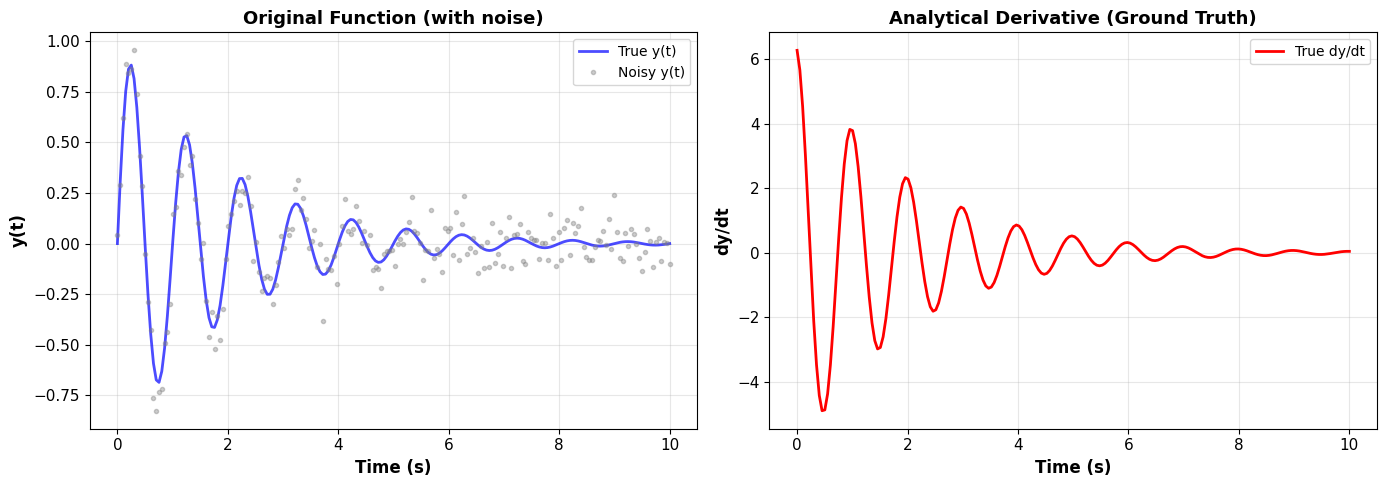

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Original function
ax1.plot(t, y_true, '-', linewidth=2, color='blue', alpha=0.7, label='True y(t)')
ax1.plot(t, y_noisy, 'o', markersize=3, alpha=0.4, color='gray', label='Noisy y(t)')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('y(t)', fontsize=12, fontweight='bold')
ax1.set_title('Original Function (with noise)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: True derivative
ax2.plot(t, dy_dt_true, '-', linewidth=2, color='red', label='True dy/dt')
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('dy/dt', fontsize=12, fontweight='bold')
ax2.set_title('Analytical Derivative (Ground Truth)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)


## Naive Differentiation: Why It Fails

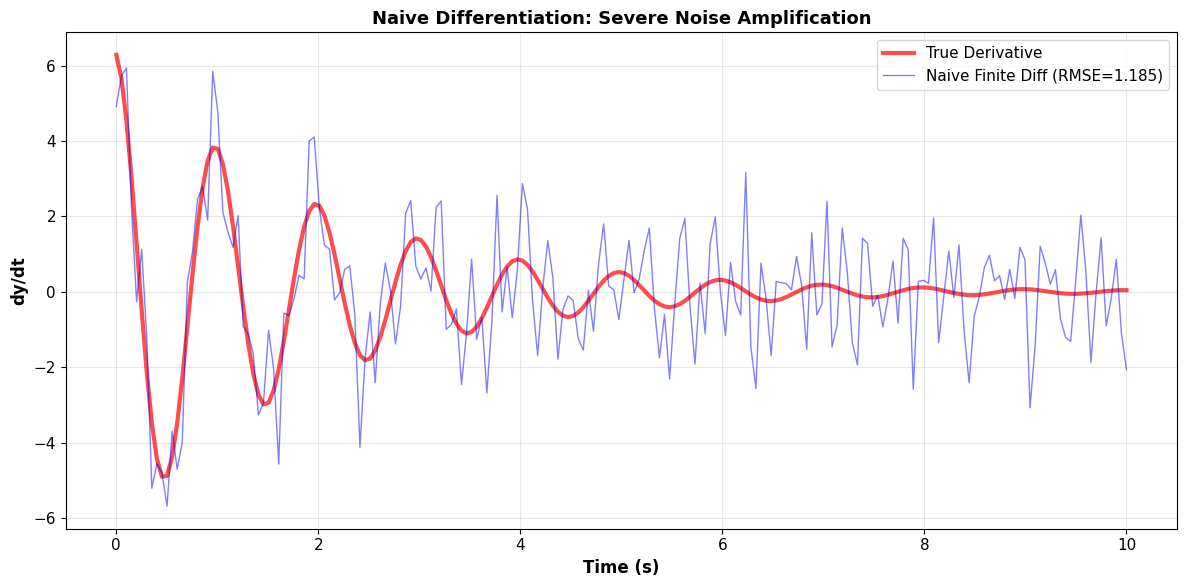


Naive differentiation RMSE: 1.1847
  ✗ Noise completely dominates the signal!


In [5]:
# Naive finite difference
dy_dt_naive = np.gradient(y_noisy, t)

# Error metrics
rmse_naive = np.sqrt(np.mean((dy_dt_naive - dy_dt_true)**2))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, dy_dt_true, '-', linewidth=3, color='red', alpha=0.7, label='True Derivative')
ax.plot(t, dy_dt_naive, '-', linewidth=1, color='blue', alpha=0.5, label=f'Naive Finite Diff (RMSE={rmse_naive:.3f})')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('dy/dt', fontsize=12, fontweight='bold')
ax.set_title('Naive Differentiation: Severe Noise Amplification', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nNaive differentiation RMSE: {rmse_naive:.4f}")
print("  ✗ Noise completely dominates the signal!")


## Apply Savitzky-Golay Derivative

In [6]:
# Create RheoData
data = RheoData(x=t, y=y_noisy, domain='time')

# Apply Savitzky-Golay derivative
savgol = SmoothDerivative(
    method='savgol',
    window_length=21,
    polyorder=3,
    deriv=1
)

derivative_data = savgol.transform(data)
dy_dt_savgol = derivative_data.y

# Error metric
rmse_savgol = np.sqrt(np.mean((dy_dt_savgol - dy_dt_true)**2))

print("Savitzky-Golay Parameters:")
print(f"  Window length: {savgol.window_length}")
print(f"  Polynomial order: {savgol.polyorder}")
print(f"  Derivative order: {savgol.deriv}")
print(f"\nRMSE: {rmse_savgol:.4f}")
print(f"Improvement over naive: {rmse_naive/rmse_savgol:.1f}x")

Savitzky-Golay Parameters:
  Window length: 21
  Polynomial order: 3
  Derivative order: 1

RMSE: 0.3353
Improvement over naive: 3.5x


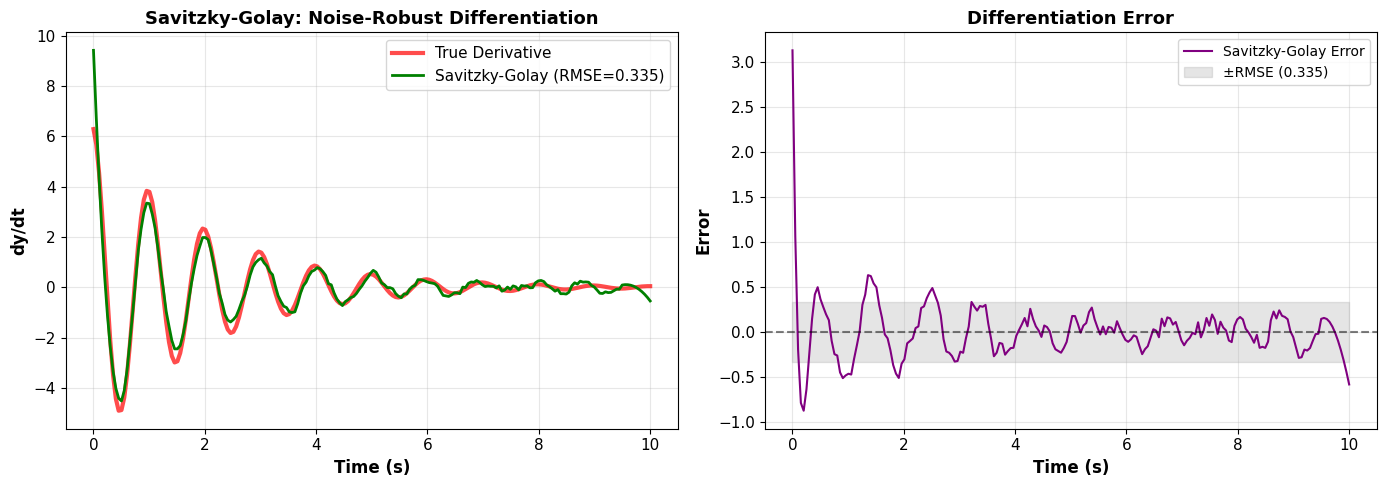


✓ Savitzky-Golay successfully recovers true derivative!


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Comparison
ax1.plot(t, dy_dt_true, '-', linewidth=3, color='red', alpha=0.7, label='True Derivative')
ax1.plot(t, dy_dt_savgol, '-', linewidth=2, color='green', label=f'Savitzky-Golay (RMSE={rmse_savgol:.3f})')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('dy/dt', fontsize=12, fontweight='bold')
ax1.set_title('Savitzky-Golay: Noise-Robust Differentiation', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right: Error analysis
error_savgol = dy_dt_savgol - dy_dt_true
ax2.plot(t, error_savgol, '-', linewidth=1.5, color='purple', label='Savitzky-Golay Error')
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(t, -rmse_savgol, rmse_savgol, alpha=0.2, color='gray', label=f'±RMSE ({rmse_savgol:.3f})')
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error', fontsize=12, fontweight='bold')
ax2.set_title('Differentiation Error', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\n✓ Savitzky-Golay successfully recovers true derivative!")


## Parameter Optimization: Window Length and Polynomial Order

In [8]:
# Test different parameter combinations
window_lengths = [7, 11, 15, 21, 31, 51]
polyorders = [2, 3, 4]

results = {}
for window in window_lengths:
    for poly in polyorders:
        if poly < window:  # Valid combination
            transform = SmoothDerivative(method='savgol', window_length=window, polyorder=poly, deriv=1)
            deriv_data = transform.transform(data)
            rmse = np.sqrt(np.mean((deriv_data.y - dy_dt_true)**2))
            results[(window, poly)] = rmse

# Find best parameters
best_params = min(results, key=results.get)
best_rmse = results[best_params]

print("Parameter Optimization Results:")
print("="*60)
for (w, p), rmse in sorted(results.items(), key=lambda x: x[1])[:5]:
    print(f"  Window={w:2d}, Poly={p} → RMSE={rmse:.4f}")
print(f"\nBest: Window={best_params[0]}, Poly={best_params[1]} → RMSE={best_rmse:.4f}")
print("="*60)

Parameter Optimization Results:
  Window=15, Poly=4 → RMSE=0.2501
  Window= 7, Poly=2 → RMSE=0.3251
  Window=21, Poly=3 → RMSE=0.3353
  Window=11, Poly=2 → RMSE=0.3460
  Window=15, Poly=3 → RMSE=0.3603

Best: Window=15, Poly=4 → RMSE=0.2501


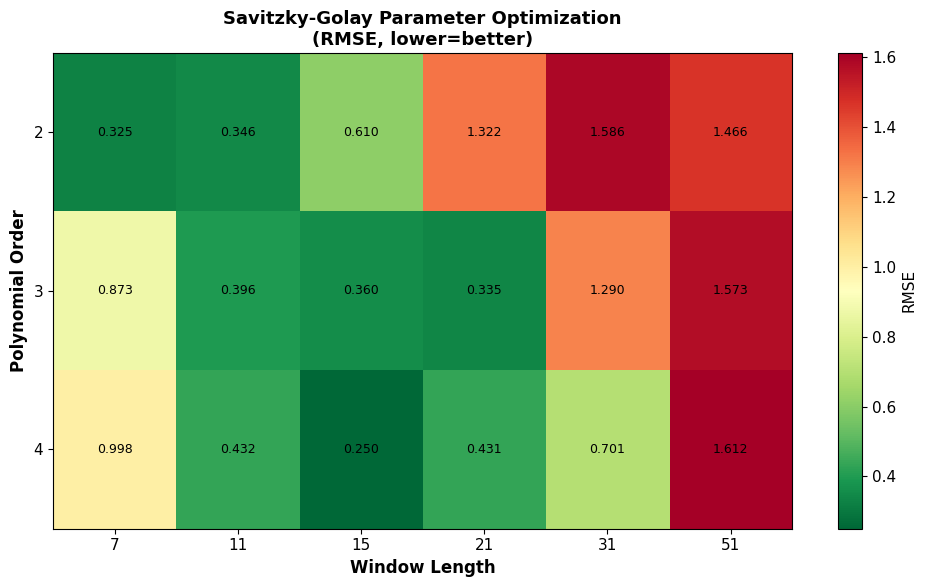


Parameter Selection Guidelines:
  • Larger window → more smoothing, less noise, lower resolution
  • Higher polynomial → better feature preservation, more noise
  • Trade-off: smoothing vs accuracy
  • Optimal: window=15-31, poly=3-4 for typical data


In [9]:
# Heatmap of RMSE vs parameters
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap
rmse_matrix = np.full((len(polyorders), len(window_lengths)), np.nan)
for i, poly in enumerate(polyorders):
    for j, window in enumerate(window_lengths):
        if (window, poly) in results:
            rmse_matrix[i, j] = results[(window, poly)]

im = ax.imshow(rmse_matrix, cmap='RdYlGn_r', aspect='auto')
ax.set_xticks(range(len(window_lengths)))
ax.set_yticks(range(len(polyorders)))
ax.set_xticklabels(window_lengths)
ax.set_yticklabels(polyorders)
ax.set_xlabel('Window Length', fontsize=12, fontweight='bold')
ax.set_ylabel('Polynomial Order', fontsize=12, fontweight='bold')
ax.set_title('Savitzky-Golay Parameter Optimization\n(RMSE, lower=better)', fontsize=13, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('RMSE', fontsize=11)

# Annotate values
for i in range(len(polyorders)):
    for j in range(len(window_lengths)):
        if not np.isnan(rmse_matrix[i, j]):
            text = ax.text(j, i, f'{rmse_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nParameter Selection Guidelines:")
print("  • Larger window → more smoothing, less noise, lower resolution")
print("  • Higher polynomial → better feature preservation, more noise")
print("  • Trade-off: smoothing vs accuracy")
print("  • Optimal: window=15-31, poly=3-4 for typical data")


## Higher-Order Derivatives

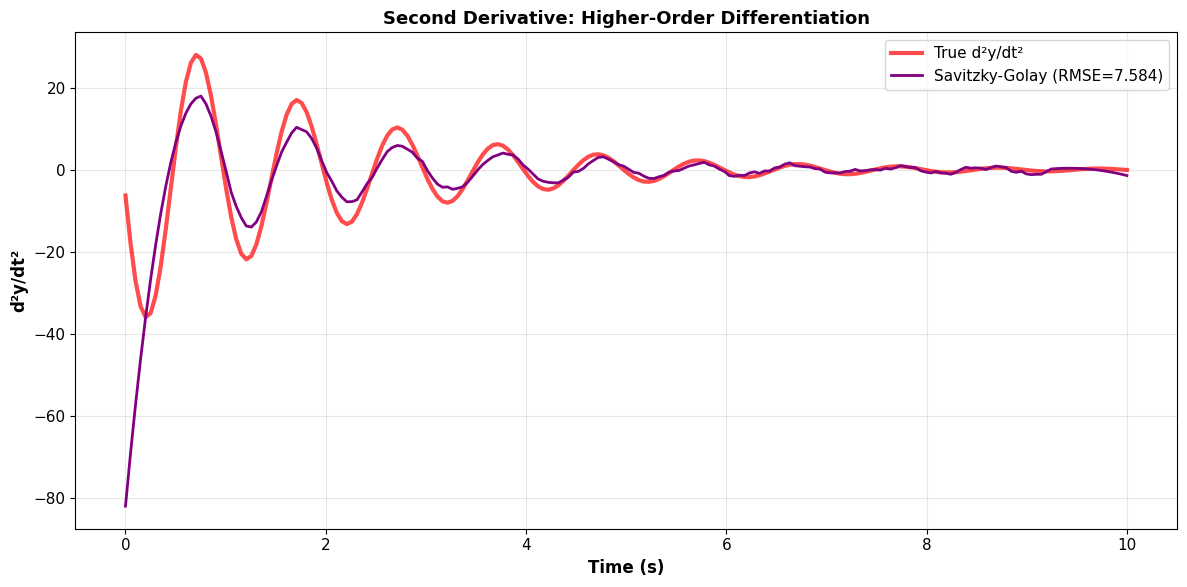

Second derivative RMSE: 7.5844
Note: Higher derivatives amplify noise more → need larger window/polyorder


In [10]:
# Analytical second derivative
d2y_dt2_true = (-0.25 * np.exp(-t/2) * np.sin(2*np.pi*t)
                - 2*np.pi * np.exp(-t/2) * np.cos(2*np.pi*t)
                - 4*np.pi**2 * np.exp(-t/2) * np.sin(2*np.pi*t))

# Compute second derivative
savgol_2nd = SmoothDerivative(method='savgol', window_length=31, polyorder=4, deriv=2)
d2_data = savgol_2nd.transform(data)
d2y_dt2_savgol = d2_data.y

rmse_2nd = np.sqrt(np.mean((d2y_dt2_savgol - d2y_dt2_true)**2))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, d2y_dt2_true, '-', linewidth=3, color='red', alpha=0.7, label='True d²y/dt²')
ax.plot(t, d2y_dt2_savgol, '-', linewidth=2, color='purple', label=f'Savitzky-Golay (RMSE={rmse_2nd:.3f})')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('d²y/dt²', fontsize=12, fontweight='bold')
ax.set_title('Second Derivative: Higher-Order Differentiation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Second derivative RMSE: {rmse_2nd:.4f}")
print("Note: Higher derivatives amplify noise more → need larger window/polyorder")


## Method Comparison

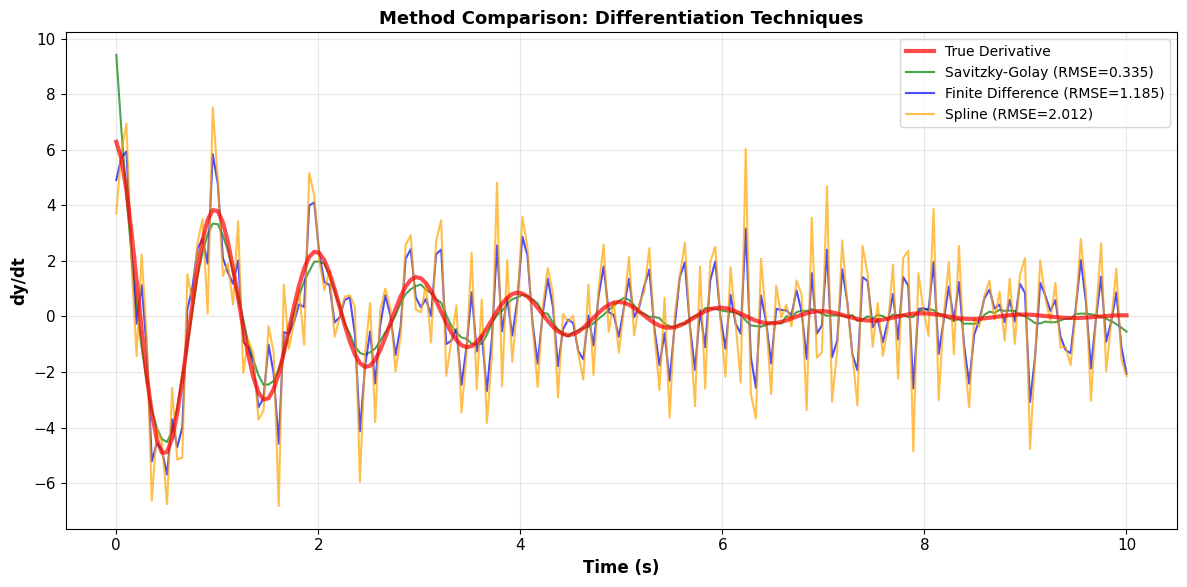


Method Recommendations:
  • Savitzky-Golay: Best for most applications (robust, accurate)
  • Finite Difference: Fast but noisy (use only for smooth data)
  • Spline: Good for smooth functions, can overshoot on peaks


In [11]:
# Compare different methods
methods = {
    'Savitzky-Golay': SmoothDerivative(method='savgol', window_length=21, polyorder=3),
    'Finite Difference': SmoothDerivative(method='finite_diff'),
    'Spline': SmoothDerivative(method='spline', polyorder=3)
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, dy_dt_true, '-', linewidth=3, color='red', alpha=0.7, label='True Derivative', zorder=10)

colors = ['green', 'blue', 'orange']
for (name, method), color in zip(methods.items(), colors):
    deriv_data = method.transform(data)
    rmse = np.sqrt(np.mean((deriv_data.y - dy_dt_true)**2))
    ax.plot(t, deriv_data.y, '-', linewidth=1.5, color=color, alpha=0.7, label=f'{name} (RMSE={rmse:.3f})')

ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('dy/dt', fontsize=12, fontweight='bold')
ax.set_title('Method Comparison: Differentiation Techniques', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nMethod Recommendations:")
print("  • Savitzky-Golay: Best for most applications (robust, accurate)")
print("  • Finite Difference: Fast but noisy (use only for smooth data)")
print("  • Spline: Good for smooth functions, can overshoot on peaks")


## Key Takeaways

### Main Concepts

**1. Noise Amplification Problem:**
- Differentiation amplifies noise (σ → σ/Δx)
- Naive finite differences fail for noisy data
- Essential to use noise-robust methods

**2. Savitzky-Golay Filter:**
- Fits local polynomials, computes analytical derivatives
- Preserves peak positions better than smoothing
- Single-pass operation (efficient)
- Recommended for most applications

**3. Parameter Selection:**
- Window length: 15-31 typical for noisy data
- Polynomial order: 3-4 balances accuracy vs noise
- Larger window → more smoothing, less resolution
- Higher polynomial → better features, more noise

**4. Higher-Order Derivatives:**
- More sensitive to noise
- Require larger windows and higher polynomial orders
- Often needed for rheological analysis

**5. Practical Guidelines:**
- Always visualize derivative vs expected behavior
- Optimize parameters on representative data
- Consider smoothing before differentiation for very noisy data
- Validate with analytical test cases when possible

### Applications in Rheology

**Strain Rate Calculation:**
- γ̇(t) = dγ/dt from strain data
- Essential for viscosity calculation

**Material Function Conversions:**
- Creep compliance → relaxation modulus
- Requires derivatives + numerical inversion

**Structural Evolution:**
- dG'/dt during gelation
- Aging kinetics

## Next Steps

### Related Notebooks
- **[01-fft-analysis.ipynb](./01-fft-analysis.ipynb)**: Alternative to time-domain derivatives
- **[03-mutation-number.ipynb](./03-mutation-number.ipynb)**: Integral-based analysis (complementary)
- **[02-mastercurve-tts.ipynb](./02-mastercurve-tts.ipynb)**: Differentiation in shift factor optimization

### Advanced Topics
- Total variation regularization for edge-preserving derivatives
- Adaptive window selection based on local curvature
- Uncertainty propagation in derivative calculations

---

## Session Information

In [12]:
import sys

import scipy

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.6.0
JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.5
SciPy version: 1.17.0
Matplotlib version: 3.10.8
